In [63]:
# Import libraries
import pandas as pd
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import numpy as np

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# nltk
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

In [2]:
df = pd.read_csv('Data/airline_labelled.csv',parse_dates=['date'])

In [3]:
df.head()

,airline_name,author,date,content,dominant_topic
0,british airways,russ king,1970-01-01,sin-lhr ba12 b747-436 first class. old aircraf...,0.0
1,jet airways,mike vaz,2007-04-14,stansted to las vegas return. check-in for bot...,0.0
2,jet airways,j patton,2007-04-14,stn-las-stn very enjoyable trip on both flight...,0.0
3,jet airways,andres mesa,2007-04-19,stn-las-stn. slow check-in resulted from repet...,0.0
4,tacv cabo,j van den berg,2007-04-19,all domestic flights (5 in total) were on time...,0.0


In [4]:
df.shape

(80520, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80520 entries, 0 to 80519
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   airline_name    80520 non-null  object        
 1   author          80520 non-null  object        
 2   date            80520 non-null  datetime64[ns]
 3   content         80520 non-null  object        
 4   dominant_topic  80520 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 3.1+ MB


In [6]:
# Check for null
df.isnull().sum()

airline_name      0
author            0
date              0
content           0
dominant_topic    0
dtype: int64

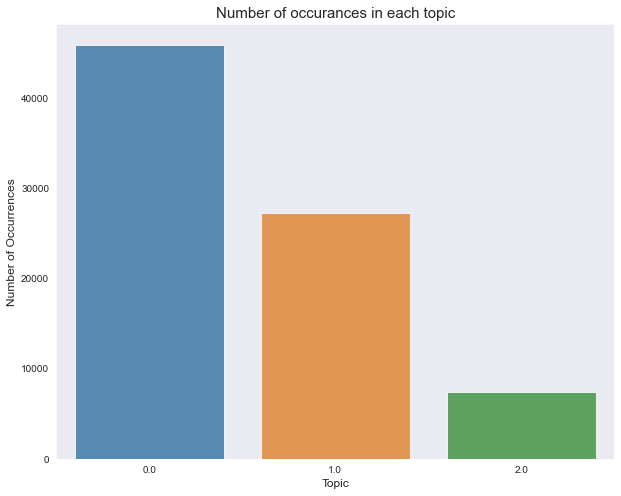

In [7]:
topicvalue = df['dominant_topic'].value_counts()
plt.figure(figsize=[10,8])
sns.set_style("dark")
sns.barplot(topicvalue.index, topicvalue.values, alpha=0.8)
plt.title('Number of occurances in each topic',fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Topic', fontsize=12)
plt.show()

### Data Cleaning

In [8]:
# Keep only alphabet, digit and space:
df['content'] = df['content'].map(lambda s: re.sub(r'[\W_]+', ' ', s))
df.head()

,airline_name,author,date,content,dominant_topic
0,british airways,russ king,1970-01-01,sin lhr ba12 b747 436 first class old aircraft...,0.0
1,jet airways,mike vaz,2007-04-14,stansted to las vegas return check in for both...,0.0
2,jet airways,j patton,2007-04-14,stn las stn very enjoyable trip on both flight...,0.0
3,jet airways,andres mesa,2007-04-19,stn las stn slow check in resulted from repeti...,0.0
4,tacv cabo,j van den berg,2007-04-19,all domestic flights 5 in total were on time t...,0.0


In [9]:
# Remove non-english words
import nltk
words = set(nltk.corpus.words.words())

for i, sent in enumerate(df.loc[:,'content']):
    " ".join(w for w in nltk.wordpunct_tokenize(sent) \
                                if w.lower() in words or not w.isalpha())

In [10]:
# Sanity check
df.head()

,airline_name,author,date,content,dominant_topic
0,british airways,russ king,1970-01-01,sin lhr ba12 b747 436 first class old aircraft...,0.0
1,jet airways,mike vaz,2007-04-14,stansted to las vegas return check in for both...,0.0
2,jet airways,j patton,2007-04-14,stn las stn very enjoyable trip on both flight...,0.0
3,jet airways,andres mesa,2007-04-19,stn las stn slow check in resulted from repeti...,0.0
4,tacv cabo,j van den berg,2007-04-19,all domestic flights 5 in total were on time t...,0.0


### Pre-processing

In [11]:
# Number of reviews before year 2018
print(len(df[df['date'] <= '2017-12-31']))

# Number of reviews for year 2018 onwards
print(len(df[df['date'] > '2017-12-31']))

65199
15321


In [12]:
# Before Year 2018
df[df['date'] <= '2017-12-31']['dominant_topic'].value_counts(normalize=True)

0.0    0.620868
1.0    0.285802
2.0    0.093330
Name: dominant_topic, dtype: float64

In [13]:
# Year 2018 onwards
df[df['date'] > '2017-12-31']['dominant_topic'].value_counts(normalize=True)

1.0    0.559755
0.0    0.356308
2.0    0.083937
Name: dominant_topic, dtype: float64

In [14]:
# test to train ratio
len(df[df['date'] > '2017-12-31']) / len(df[df['date'] <= '2017-12-31'])

0.23498826669120693

In [15]:
# Split train and test by dates
train = df[df['date'] <= '2017-12-31']
test = df[df['date'] > '2017-12-31']

In [16]:
# Train-test-split
X_train = train['content']
y_train = train['dominant_topic']
X_test = test['content']
y_test = test['dominant_topic']

## Modelling

### TF-IDF and Logistic Regression

In [31]:
# instantiate
tvec = TfidfVectorizer()
lr_tf = LogisticRegression(max_iter=1000)

In [32]:
# Setup pipeline
pipe_tvec = make_pipeline(tvec,lr_tf)

In [19]:
# Set the pipe params
pipe_tvec_params = {
    'tfidfvectorizer__min_df': [2, 3],
    'tfidfvectorizer__max_df': [.9, .95],
    'logisticregression__C': [0.9,0.8], 
}

In [20]:
# Instantiate gridsearchCV
gs_tvec = GridSearchCV(pipe_tvec,
                     param_grid=pipe_tvec_params,
                     cv=5,
                     verbose=1)

In [21]:
# Fit gridsearch
gs_tvec.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 11.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.9, 0.8],
                         'tfidfvectorizer__max_df': [0.9, 0.95],
                         'tfidfvectorizer__min_df': [2, 3]},
             verbose=1)

In [22]:
# Gridsearch best score
gs_tvec.best_score_

0.9311493645538139

In [23]:
# Get the best hyperparameters
gs_tvec.best_params_

{'logisticregression__C': 0.9,
 'tfidfvectorizer__max_df': 0.9,
 'tfidfvectorizer__min_df': 3}

In [24]:
# Score model on training set
gs_tvec.score(X_train,y_train)

0.96343502200954

In [25]:
# Score model on testing set
gs_tvec.score(X_test,y_test)

0.9442595130866132

### Reduce overfitting
Here we will try to reduce overfitting on the model by increasing the regularization 

In [50]:
# instantiate
tvec = TfidfVectorizer(max_df=0.9,
                       min_df=3,
                       stop_words='english')
lr_tf = LogisticRegression(max_iter=1000)

In [51]:
# Setup pipeline
pipe_tvec2 = make_pipeline(tvec,lr_tf)

In [52]:
# Set the pipe params
pipe_tvec_params2 = {
    'tfidfvectorizer__max_features': [1000,2000],
    'logisticregression__C': [0.8,0.7], 
}

In [53]:
# Instantiate gridsearchCV
gs_tvec2 = GridSearchCV(pipe_tvec2,
                     param_grid=pipe_tvec_params2,
                     cv=5,
                     verbose=1)

In [54]:
# Fit gridsearch
gs_tvec2.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(max_df=0.9, min_df=3,
                                                        stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.8, 0.7],
                         'tfidfvectorizer__max_features': [1000, 2000]},
             verbose=1)

In [55]:
# Get the best hyperparameters
gs_tvec2.best_params_

{'logisticregression__C': 0.8, 'tfidfvectorizer__max_features': 2000}

In [56]:
# Score model on training set
gs_tvec2.score(X_train,y_train)

0.9474838571143729

In [57]:
# Score model on testing set
gs_tvec2.score(X_test,y_test)

0.939364271261667

In [66]:
# Save the best model 
gs_tvec_model = gs_tvec2.best_estimator_

### Top Features

The top features included words that are relevant to the topics that we have labelled. 

In [67]:
# Get top features in the model

eli5.show_weights(gs_tvec_model.named_steps['logisticregression'], vec=gs_tvec_model.named_steps['tfidfvectorizer'], top=(10,10),target_names=y_test)

In [68]:
# make pred on y_test
y_pred = gs_tvec2.predict(X_test)

In [69]:
# Confusion matrix
tvec_matrix = confusion_matrix(y_test,y_pred)
tvec_matrix

array([[5250,  155,   54],
       [ 252, 8187,  137],
       [ 140,  191,  955]], dtype=int64)

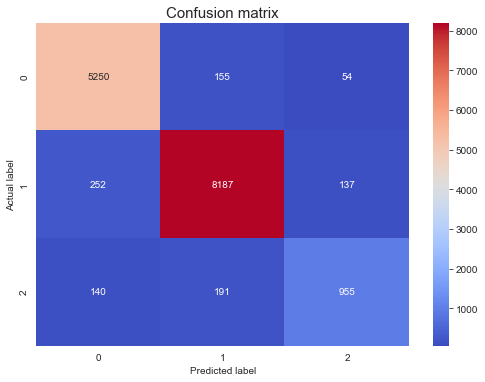

In [70]:
# Plot Confusion matrix
label_names=[0,1,2]
fig, ax = plt.subplots(figsize=(7,5))
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names)
plt.yticks(tick_marks, label_names)
sns.heatmap(pd.DataFrame(tvec_matrix), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1, fontsize=15)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [71]:
# Classification score
tvec_report = classification_report(
    digits=2,
    y_true=y_test,
    y_pred=gs_tvec2.predict(X_test)
)

print(tvec_report)

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      5459
         1.0       0.96      0.95      0.96      8576
         2.0       0.83      0.74      0.79      1286

    accuracy                           0.94     15321
   macro avg       0.91      0.89      0.90     15321
weighted avg       0.94      0.94      0.94     15321



In [72]:
# ROC AUC score
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)

    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    return roc_auc_score(y_test, y_pred, average=average)

multiclass_roc_auc_score(y_test,gs_tvec2.predict(X_test))

0.9257189314468871